# Unsupervised Image retrieval

## Import the libraries

In [3]:
import numpy as np
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.datasets import mnist, cifar10
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from keras.models import load_model
from sklearn.metrics import label_ranking_average_precision_score

Using TensorFlow backend.


## Load the training data

In [4]:
(X_train, y_train),(X_test, y_test) = mnist.load_data()

In [5]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

In [6]:
print(X_train.shape, X_test.shape)

(60000, 28, 28) (10000, 28, 28)


In [7]:
X_train = np.reshape(X_train, (len(X_train), 28, 28, 1))
X_test = np.reshape(X_test, (len(X_test), 28, 28, 1))

In [8]:
print(X_train.shape, X_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


## Create the autoencoder

In [9]:
input_img = Input(shape=(28,28,1))
x = Conv2D(16,(3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8,(3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8,(3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same', name='encoder')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

## Train it

In [11]:
autoencoder.fit(X_train, X_train, epochs=2, batch_size=32, shuffle=True, validation_data=(X_test, X_test),
                    callbacks=None )

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 78s - loss: 0.1130 - val_loss: 0.1140
Epoch 2/2
60000/60000 [==============================] - 67s - loss: 0.1120 - val_loss: 0.1140


In [65]:
autoencoder.save('autoencoder.h5')

In [32]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
encoder (MaxPooling2D)       (None, 4, 4, 8)           0         
__________

## Create the encoder part

The encoder part is the first half of the autoencoder, i.e. the part that will encode the input into a latent space representation. In this case, the dimension of this representation is $4 \times 4 \times 8$   

In [23]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)

In [66]:
encoder.save('encoder.h5')

## Load the query image

We take a query image from the test set

In [24]:
query = X_test[7]

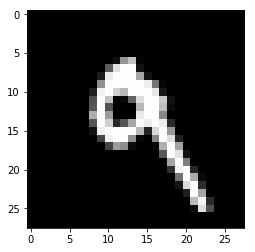

In [25]:
plt.imshow(query.reshape(28,28), cmap='gray')

## Encode the test images and the query image

In [26]:
X_test.shape

(10000, 28, 28, 1)

We remove the query image from the test set (the set in which we will search for close images)

In [27]:
X_test_a = np.delete(X_test, 7, axis=0)

In [28]:
X_test_a.shape

(9999, 28, 28, 1)

### Encode the query image and the test set

In [29]:
codes = encoder.predict(X_test_a)

In [46]:
query_code = encoder.predict(query.reshape(1,28,28,1))

In [31]:
codes.shape

(9999, 4, 4, 8)

In [32]:
query_code.shape

(1, 4, 4, 8)

## Find the closest images

In [36]:
from sklearn.neighbors import NearestNeighbors

In [37]:
number_elements = 5

In [47]:
codes = codes.reshape(9999, 4*4*8); print(codes.shape)
query_code = query_code.reshape(1, 4*4*8); print(query_code.shape)

(9999, 128)
(1, 128)


### Fit the KNN to the test set

In [39]:
nbrs = NearestNeighbors().fit(codes)

In [49]:
query_code_centroid = np.mean(query_code, axis=0)

In [50]:
query_code_centroid = query_code_centroid.reshape(1,128)

In [51]:
query_code_centroid.shape

(1, 128)

In [59]:
distances, indices = nbrs.kneighbors(np.array(query_code))

In [60]:
found_images = X_test_a[indices]

In [61]:
found_images = found_images.reshape(5,28,28,1)

In [62]:
found_images.shape

(5, 28, 28, 1)

## Get the closest images

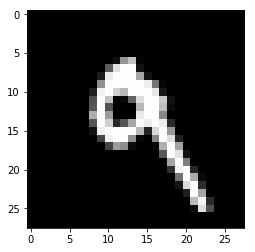

In [63]:
plt.imshow(query.reshape(28,28), cmap='gray')

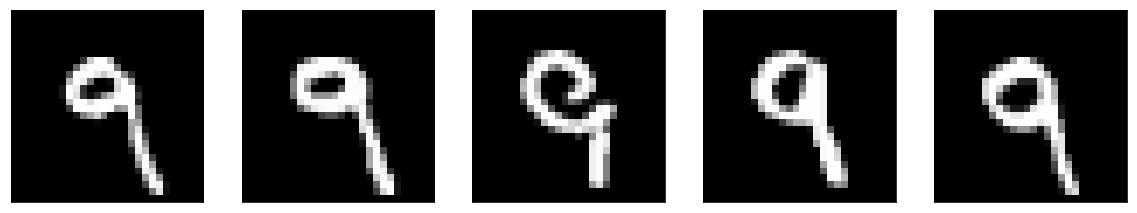

In [64]:
plt.figure(figsize=(20, 6))
for i in range(number_elements):
    # display original
    ax = plt.subplot(1, number_elements, i+1)
    plt.imshow(found_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()